In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable,vstack
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
from tqdm import tqdm


import functions
#import upsilon

In [4]:
def gaussian1(x,c,mu,sigma):
    return c*np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian2(x,c1,mu1,sigma1,c2,mu2,sigma2):
    return c1 * np.exp(-(x-mu1)**2/(2*sigma1**2))+c2*np.exp(-(x-mu2)**2/(2*sigma2**2))

def lorentzian(x,c,cen,wid):
    return c*wid**2/((x-cen)**2+wid**2)

(5.214567990408157, 0.10173584770002377, 3.9969548708248186)

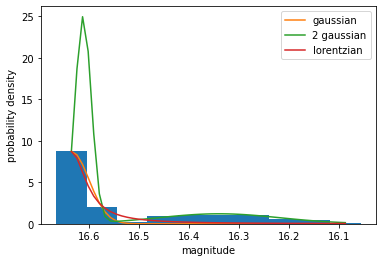

In [4]:
ztf_ID=806203100056802
t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
#remove bad flags
t=t[t['catflags']==0]
# remove bad days
t=t[(t['mjd']<58481*u.day)|(t['mjd']>58482*u.day)]
t=t[(t['mjd']<58472*u.day)|(t['mjd']>58474*u.day)]
t=t[(t['mjd']<59032*u.day)|(t['mjd']>59033*u.day)]

mag=np.array(t['mag'])

histo=np.histogram(mag,bins=10,density=1)
x=(histo[1][:-1]+histo[1][1:])/2
y=histo[0]

popt_g1,pcov_g1 = curve_fit(gaussian1,x,y,p0=[1,x.mean(),x.std()],bounds=([0,x.min(),0],[50,x.max(),x.max()-x.min()]))
popt_g2,pcov_g2 = curve_fit(gaussian2,x,y,p0=[1,x.mean(),x.std(),1,x.mean(),x.std()],bounds=([0,x.min(),0,0,x.min(),0],[50,x.max(),x.max()-x.min(),50,x.max(),x.max()-x.min()]))
popt_l,pcov_l = curve_fit(lorentzian,x,y,p0=[1,x.mean(),x.std()],bounds=([0,x.min(),0],[50,x.max(),x.max()-x.min()]))


plt.hist(mag,bins=10,density=1)

xx=np.linspace(x.min(),x.max(),50)
plt.plot(xx,gaussian1(xx,popt_g1[0],popt_g1[1],popt_g1[2]),label='gaussian')
plt.plot(xx,gaussian2(xx,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]),label='2 gaussian')
plt.plot(xx,lorentzian(xx,popt_l[0],popt_l[1],popt_l[2]),label='lorentzian')


plt.xlabel('magnitude')
plt.ylabel('probability density')
plt.gca().invert_xaxis()
plt.legend()

sqerr_gaussian1=((y-gaussian1(x,popt_g1[0],popt_g1[1],popt_g1[2]))**2).sum()
sqerr_gaussian2=((y-gaussian2(x,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]))**2).sum()
sqerr_lorentzian=((y-lorentzian(x,popt_l[0],popt_l[1],popt_l[2]))**2).sum()
sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian

(5.214567990408157, 0.10173584770002377, 3.9969548708248186)

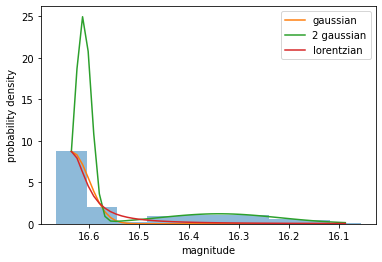

In [5]:
functions.fit_mag(806203100056802)

(1.23399967185499, 0.04572083548845897, 1.2035426085810343)

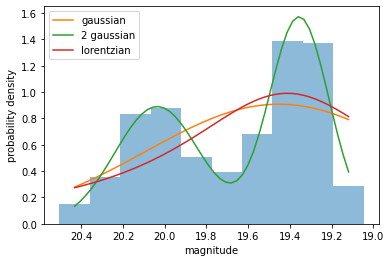

In [6]:
functions.fit_mag(806203100063224)

In [2]:
t=QTable.read('t_zr_0926.ecsv')

for i,row in tqdm(enumerate(t),total=len(t)):
    if np.isnan(row['mean']):
        #print('This guy has too few observations')
        t[i]['gaussian1_err']=99999
        t[i]['gaussian2_err']=99999
        t[i]['lorentzian_err']=99999
    else:
        sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian=functions.fit_mag(str(int(row['OID'])),plot=False)
        
        t[i]['gaussian1_err']=sqerr_gaussian1
        t[i]['gaussian2_err']=sqerr_gaussian2
        t[i]['lorentzian_err']=sqerr_lorentzian
        
        #_=input('debug')
        
        
t.write('t_zr_0928.ecsv')
astropy.utils.data.clear_download_cache()

  4%|███▏                                                                          | 98/2407 [04:01<1:34:12,  2.45s/it]

2nd download attempt in 30 seconds...


  9%|██████▉                                                                      | 216/2407 [09:42<1:54:17,  3.13s/it]

2nd download attempt in 30 seconds...


  9%|███████                                                                      | 222/2407 [10:41<2:41:28,  4.43s/it]

2nd download attempt in 30 seconds...


100%|████████████████████████████████████████████████████████████████████████████| 2407/2407 [2:02:14<00:00,  3.05s/it]


In [3]:
t=QTable.read('t_zg_0926.ecsv')

for i,row in tqdm(enumerate(t),total=len(t)):
    if np.isnan(row['mean']):
        #print('This guy has too few observations')
        t[i]['gaussian1_err']=99999
        t[i]['gaussian2_err']=99999
        t[i]['lorentzian_err']=99999
    else:
        sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian=functions.fit_mag(str(int(row['OID'])),plot=False)
        
        t[i]['gaussian1_err']=sqerr_gaussian1
        t[i]['gaussian2_err']=sqerr_gaussian2
        t[i]['lorentzian_err']=sqerr_lorentzian
        
        #_=input('debug')
        
        
t.write('t_zg_0928.ecsv')
astropy.utils.data.clear_download_cache()

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1256/1334 [57:14<04:06,  3.16s/it]

2nd download attempt in 30 seconds...


100%|████████████████████████████████████████████████████████████████████████████| 1334/1334 [1:01:46<00:00,  2.78s/it]


In [36]:
t_zr=QTable.read('t_zr_0928.ecsv')
t_zg=QTable.read('t_zg_0928.ecsv')

In [10]:
shapes=['g1','g2','l','nc']

for row in t_zr:
    if np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).min()==99999:
        ishape=3
    elif row['gaussian1_err']==row['gaussian2_err']:
        ishape=0
    else:
        ishape=np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).argmin()
    
    row['shape']=shapes[ishape]
    
for row in t_zg:
    if np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).min()==99999:
        ishape=3
    elif row['gaussian1_err']==row['gaussian2_err']:
        ishape=0
    else:
        ishape=np.array([row['gaussian1_err'],row['gaussian2_err'],row['lorentzian_err']]).argmin()
    
    row['shape']=shapes[ishape]
    
t_zr.write('t_zr_0928.ecsv',overwrite=True)
t_zg.write('t_zg_0928.ecsv',overwrite=True)

In [16]:
t_zr=QTable.read('t_zr_0928.ecsv')
t_zg=QTable.read('t_zg_0928.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

var_zr=t_zr[t_zr['sf']<1/(100*len(t_zr))] #99% chance variabe
var_zg=t_zg[t_zg['sf']<1/(100*len(t_zg))] #99% chance variabe

nonvar_zr=t_zr[t_zr['sf']>1/(100*len(t_zr))]
nonvar_zg=t_zg[t_zg['sf']>1/(100*len(t_zg))]

In [17]:
def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

t_zr=cut_LNP_SIG(var_zr,_,1/(100*len(t_zr)))
t_zg=cut_LNP_SIG(var_zg,_,1/(100*len(t_zg)))


# cut power ratios
obj_zr=t_zr[t_zr['power']/t_zr['power_c']>=1]
obj_zg=t_zg[t_zg['power']/t_zg['power_c']>=1]


# cut close periods
obj_zr=obj_zr[np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>1e-2]
obj_zg=obj_zg[np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>1e-2]

obj_zr=obj_zr[(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']<0.49)|(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>0.91)|(obj_zr['LNP_SIG']<1e-30)]
obj_zg=obj_zg[(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']<0.49)|(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>0.91)|(obj_zg['LNP_SIG']<1e-30)]




# restore original table for ploting reasons
t_zr=QTable.read('t_zr_0928.ecsv')
t_zg=QTable.read('t_zg_0928.ecsv')

# choose only OID with highest numobs
mask=np.zeros(len(obj_zr))+1
for i,obj in enumerate(obj_zr):
    copy=t_zr[t_zr['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zr=obj_zr[mask==1]


mask=np.zeros(len(obj_zg))+1
for i,obj in enumerate(obj_zg):
    copy=t_zg[t_zg['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zg=obj_zg[mask==1]

In [18]:
obj_zr.show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
0,52,zr,806203100023276,5.0806496,59.3093092,664,48.39557647705078,9.548270702053268,1.3227187319910005e-189,0.3108588755130768,1.7018337280194596e-78,595.2450708466688,0.997336033066433,0.6229683753591274,0.21949631231274336,19.675853729248047,0.3108588755130768,19.17412567138672,20.918895721435547,-0.7161276936531067,3.285275936126709,0.05060820837846773,0.004147348221080387,0.017392958455461623,g2,LPV_OSARG_AGB,0.33,0.0,566.9630815875007
1,77,zr,806203100063307,5.0870906,59.2998095,836,344.7351989746094,40.842491010031104,0.0,0.22717958688735962,7.488112388238467e-24,26.55255504914417,0.997336033066433,0.25554257162342087,0.0034232661997002983,18.791976928710938,0.22717958688735962,17.675485610961914,19.1998348236084,-0.8078729510307312,6.599571704864502,0.010941249145676618,0.00224518287311395,0.00994864396700629,g2,CEPH_Other,0.44,0.0,26.524588612280738
2,90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,0.18947997524899735,0.020160516717319308,0.18369036401023547,g2,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003
3,145,zr,806203100043772,5.0957151,59.2994528,717,66.61664581298828,3.5379984089296954,2.2753838245357322e-18,0.14171883463859558,1.0515294240953812e-12,981.7766691905116,0.997336033066433,0.17591322363193937,0.09890003454859338,19.4619083404541,0.14171883463859558,18.99640655517578,20.149547576904297,-0.18844391405582428,1.9061943292617798,0.014671908105194727,0.001276176864321731,0.03889499255846222,g2,NonVar,0.35,0.0,1133.9261631750014
4,158,zr,806203100057075,5.0953672,59.297784,702,85.88482666015625,6.528562040377028,1.9791103413711206e-94,0.179270938038826,5.255097789862924e-52,595.2450708466688,0.997336033066433,0.4806277327856466,0.1408160323876546,19.39754295349121,0.179270938038826,18.829944610595703,19.830501556396484,-0.3216327726840973,2.6130337715148926,0.04033987890789587,0.018236393709792853,0.10527077602560657,g2,LPV_SRV_AGB_O,0.39,0.0,647.9578075285723
5,168,zr,806203100060423,5.0989475,59.3023316,603,43.353397369384766,3.6096865088249213,9.805802856611858e-19,0.20166358351707458,5.211841335015464e-23,481.50270086755603,0.997336033066433,0.28793891233976,0.19382587404148513,19.980669021606445,0.20166358351707458,19.334941864013672,20.572986602783203,-0.2577386200428009,1.9497979879379272,0.022887622012299862,0.005203362116569448,0.05488367114649255,g2,LPV_OSARG_AGB,0.26,0.0,503.96718363333395
6,208,zr,806203100063224,5.064121,59.3186488,785,57.229671478271484,14.973554136565346,0.0,0.36998096108436584,5.372709522621155e-121,706.5076598069519,0.997336033066433,0.7610530058290755,0.04136356170280423,19.66598129272461,0.36998096108436584,19.045684814453125,20.505390167236328,-1.0772920846939087,4.238379955291748,0.1762856674078557,0.011430208872114742,0.17193465836871918,g2,LPV_OSARG_AGB,0.4,0.0,647.9578075285723
7,210,zr,806203100060348,5.0498178,59.314207,524,46.50968933105469,7.160523506839386,1.1875559898120985e-83,0.2575588822364807,6.041918640486786e-47,2042.1167531644894,0.997343815080248,0.5563482426780246,0.48559856224556536,19.789920806884766,0.2575588822364807,19.26156234741211,20.64164161682129,-0.4833795726299286,2.7955565452575684,0.03952169106555757,0.02287524518372877,0.03933460223783365,g2,LPV_SRV_AGB_O,0.26,0.0,1508.9202546000013
8,223,zr,806203100043707,5.1028196,59.3033683,846,183.5657958984375,4.092027802756495,2.7699515132378596e-33,0.06768444925546646,2.4417471025797287e-53,706.5076598069519,0.997336033066433,0.45527247001007415,0.03107799344601829,18.26998519897461,0.0676

In [19]:
obj_zg.show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
0,73,zg,806103100048650,5.0758587,59.2958026,97,64.1142578125,8.935053528431245,1.364237212874404e-43,0.23146717250347137,1.5286033678611772e-06,1.0323211002809742,0.9972896868175051,0.35458712707540346,0.17918306600135617,20.327228546142578,0.23146717250347137,19.153165817260742,20.794662475585938,-0.3369257152080536,3.0768370628356934,0.009533435201166616,0.005878561126446088,0.030943203302743676,g2,CEPH_Other,0.49,1.0,2.150138196410262
1,77,zg,806103100029923,5.0869784,59.2997881,258,80.47639465332031,16.358047581022113,8.308402166762659e-291,0.31344184279441833,2.3170100655180286e-16,26.55360081018743,1.0000143393856216,0.29023605619128945,0.005352919590317105,20.02450942993164,0.31344184279441833,18.832887649536133,20.759401321411133,-0.705572783946991,4.285964488983154,0.012970668406877212,0.004716468235863393,0.02181115743512546,g2,CEPH_Other,0.42,0.0,26.525643273684214
2,90,zg,806103100049624,5.0834336,59.3114529,324,188.7042694091797,29.36702577363452,0.0,0.29480019211769104,3.044761670180407e-168,2043.2292424728973,1.0000143393856216,0.9125489407249586,0.43350509622734634,18.898109436035156,0.29480019211769104,18.297286987304688,19.611181259155273,-1.0131325721740723,5.650538921356201,0.23967240405386964,0.05805683738638916,0.17635973392859552,g2,LPV_OSARG_AGB,0.31,0.0,1511.9616666
3,443,zg,806103100029740,5.0330754,59.3138586,121,28.574586868286133,3.3070619221753326,6.971346953456639e-06,0.26791107654571533,3.359681295461664e-06,29.544695873850177,0.9973551322251167,0.2801948798759783,0.2318731325804575,21.151514053344727,0.26791107654571533,20.161453247070312,21.6740779876709,-0.17529430985450745,1.8428221940994263,0.010316456296390868,0.005673659256583021,0.007538279203588605,g2,T2CEPH,0.27,1.0,29.58474232302639
4,959,zg,806103100020224,5.004683,59.2957142,88,36.86333084106445,4.684628152743749,1.3916365366418321e-11,0.2844848036766052,6.385254250041842e-06,0.9693858486637983,0.9972475558737529,0.3530172255660577,0.07943363226649049,21.140100479125977,0.2844848036766052,19.84897232055664,21.54222869873047,-0.21879763901233673,2.201746702194214,0.009208055284775255,0.005342129553169445,0.011790159592967203,g2,CEPH_Other,0.55,1.0,0.9693417887075744
5,1219,zg,806103100019623,5.1471037,59.3192505,227,50.598838806152344,3.1444243020941505,6.549911462187277e-08,0.19112929701805115,6.941202255880496e-07,29.447495953900567,0.997381150869086,0.17618709053449363,0.09778859934213133,20.59395980834961,0.19112929701805115,19.435989379882812,21.078689575195312,-0.1532217562198639,1.797919750213623,0.021734857847221237,0.0002688011853977678,0.0011603298045622136,g2,CEPH_Other,0.19,1.0,29.563396567549706
6,1642,zg,806103400000039,5.125632,59.2614822,193,319.8429260253906,3.8277717316687054,2.0313202423838072e-13,0.03029390051960945,9.879192641170996e-17,333.4203659481394,1.000014139092549,0.3710084864897626,0.061699838152285046,14.649717330932617,0.03029390051960945,14.5626220703125,14.71679973602295,-0.004198555834591389,1.951535940170288,4.1937360859648045,0.9603902675870942,1.7014916732827916,g2,LPV_OSARG_RGB,0.77,0.0,324.4204513928578
7,1742,zg,806103100036041,5.1657575,59.3264781,100,39.18263626098633,5.1370541115192,9.344332088315628e-16,0.2907710373401642,1.1622696420569923e-06,1.0350954501329348,0.9973150583083484,0.3479967454274027,0.32068001120018785,21.214624404907227,0.2907710373401642,19.77669334411621,21.729793548583984,-0.22576093673706055,2.3101282119750977,0.007643579313481903,0.0019145462956529798,0.022385178028946524,g2,CEPH_Other,0.47,1.0,0.9646255847324385
8,2091,zg,806103100042527,5.0300812,59.3603736,327,117.55354309082031,7.327556527488163,1.7014568121167147e-100,0.16449441015720367,1.4177251368775485e-06,29.449981881281207,1.0000143393856216,0.12390738368110

In [8]:
functions.query(1706)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
1706,zr,806203400000031,5.136092,59.2636288,461,431.9645080566406,11.675422385585875,2.6551987521882357e-142,0.08870050311088562,1.0860549931944522e-11,1.4577603815834215,0.9999745929464803,0.27642502509656847,0.0044000268003915365,17.650800704956055,0.08870050311088562,17.491008758544922,18.03772735595703,-0.16741064190864563,3.4192874431610107,0.8896796613441509,0.038460013712527934,0.6550278746682832,g2,EB_ED,1.0,0.0,1.4579571368370317
1706,zr,1809211300009503,5.1361172,59.2636144,77,369.04840087890625,13.681209897767802,2.4339530432499525e-67,0.08886002749204636,0.001330129344638277,0.5921424828972771,2800.0,0.30724042947682273,0.010063787598541072,17.64644432067871,0.08886002749204636,17.563995361328125,17.967727661132812,-0.1830681711435318,3.6865057945251465,2.64381809230099,0.5878332709123695,1.3001125365329607,g2,EB_ED,1.0,1.0,0.5921093749999992


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
1706,zg,806103400000010,5.1360736,59.2636276,183,169.36692810058594,5.930396478100423,4.522011409405008e-38,0.1094631478190422,0.00011061529020928772,0.7288683457753534,0.4993376374822702,0.16651371530904885,0.0016313774803064986,18.466846466064453,0.1094631478190422,18.303394317626953,18.957456588745117,-0.1544823795557022,2.4407806396484375,0.908348189433317,0.23496338016298057,0.29235913789206075,g2,EB_ED,0.97,1.0,0.7289177209918165
1706,zg,1809111300006183,5.1361215,59.2636188,65,187.9484405517578,7.402532987135602,1.1363256093283002e-21,0.1200142577290535,0.020807073627812075,0.728876742375764,2800.0,0.2868214678966257,0.008191277442766567,18.461336135864258,0.1200142577290535,18.15288543701172,18.853958129882812,-0.20063649117946625,2.7191407680511475,1.3259305362991651,0.6506731829628192,0.9336060805433158,g2,EB_ESD,0.65,1.0,0.7289147181676136


(0.12709709447773584, 0.009615003428131983, 0.09357541066689759)

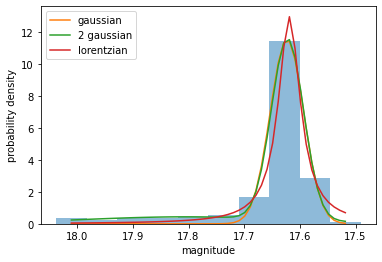

In [2]:
functions.fit_mag(806203400000031)

In [7]:
#t_zr['gaussian1_err']/=(10-3)
#t_zr['gaussian2_err']/=(10-6)
#t_zr['lorentzian_err']/=(10-3)

In [9]:
#t_zg['gaussian1_err']/=(10-3)
#t_zg['gaussian2_err']/=(10-6)
#t_zg['lorentzian_err']/=(10-3)

(1.23399967185499, 0.04572083548845897, 1.2035426085810343)

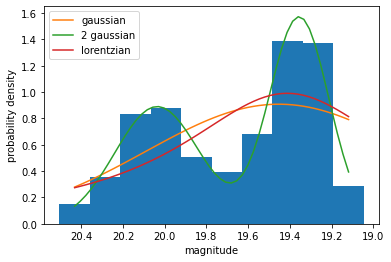

In [5]:
ztf_ID=806203100063224
t=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+str(ztf_ID))
#remove bad flags
t=t[t['catflags']==0]
# remove bad days
t=t[(t['mjd']<58481*u.day)|(t['mjd']>58482*u.day)]
t=t[(t['mjd']<58472*u.day)|(t['mjd']>58474*u.day)]
t=t[(t['mjd']<59032*u.day)|(t['mjd']>59033*u.day)]

mag=np.array(t['mag'])

histo=np.histogram(mag,bins=10,density=1)
x=(histo[1][:-1]+histo[1][1:])/2
y=histo[0]

popt_g1,pcov_g1 = curve_fit(gaussian1,x,y,p0=[1,x.mean(),x.std()],bounds=([0,x.min(),0],[50,x.max(),x.max()-x.min()]))
popt_g2,pcov_g2 = curve_fit(gaussian2,x,y,p0=[1,x.mean(),x.std(),1,x.mean(),x.std()],bounds=([0,x.min(),0,0,x.min(),0],[50,x.max(),x.max()-x.min(),50,x.max(),x.max()-x.min()]))
popt_l,pcov_l = curve_fit(lorentzian,x,y,p0=[1,x.mean(),x.std()],bounds=([0,x.min(),0],[50,x.max(),x.max()-x.min()]))


plt.hist(mag,bins=10,density=1)

xx=np.linspace(x.min(),x.max(),50)
plt.plot(xx,gaussian1(xx,popt_g1[0],popt_g1[1],popt_g1[2]),label='gaussian')
plt.plot(xx,gaussian2(xx,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]),label='2 gaussian')
plt.plot(xx,lorentzian(xx,popt_l[0],popt_l[1],popt_l[2]),label='lorentzian')


plt.xlabel('magnitude')
plt.ylabel('probability density')
plt.gca().invert_xaxis()
plt.legend()

sqerr_gaussian1=((y-gaussian1(x,popt_g1[0],popt_g1[1],popt_g1[2]))**2).sum()
sqerr_gaussian2=((y-gaussian2(x,popt_g2[0],popt_g2[1],popt_g2[2],popt_g2[3],popt_g2[4],popt_g2[5]))**2).sum()
sqerr_lorentzian=((y-lorentzian(x,popt_l[0],popt_l[1],popt_l[2]))**2).sum()
sqerr_gaussian1,sqerr_gaussian2,sqerr_lorentzian

In [8]:
pcov_g2

array([[ 1.01887318e-02, -3.06479372e-05, -6.80983332e-04,
        -1.33026215e-04, -1.72031134e-04,  1.82141089e-04],
       [-3.06479372e-05,  1.21903585e-04,  1.58708080e-05,
         1.22353916e-04,  4.27580685e-05, -7.90253051e-05],
       [-6.80983332e-04,  1.58708080e-05,  1.38373322e-04,
         1.40152587e-04,  6.41923094e-05, -1.02457909e-04],
       [-1.33026215e-04,  1.22353916e-04,  1.40152587e-04,
         7.26969831e-03,  9.49726845e-05, -1.27104435e-03],
       [-1.72031134e-04,  4.27580685e-05,  6.41923094e-05,
         9.49726845e-05,  5.28288313e-04, -6.69847498e-05],
       [ 1.82141089e-04, -7.90253051e-05, -1.02457909e-04,
        -1.27104435e-03, -6.69847498e-05,  6.24566367e-04]])

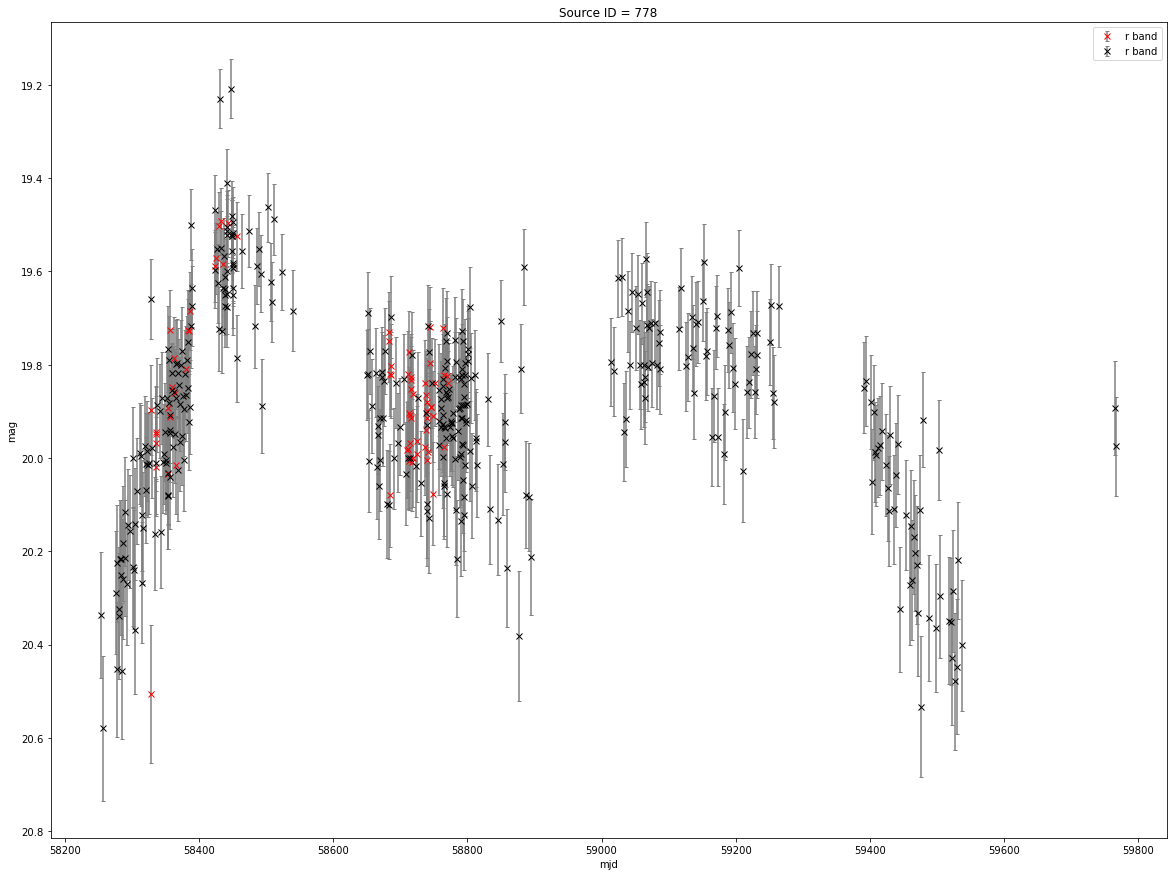

In [7]:
functions.draw_lightcurve(778)

In [2]:
functions.query(778)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
778,zr,1809211300042582,5.0116117,59.2990019,69,37.27853012084961,3.042858466843575,0.0036174858773146954,0.1601543426513672,3.397075993647798e-13,1.0025797704878305,2800.0,0.6667381062035251,0.735897607830983,19.858922958374023,0.1601543426513672,19.492298126220703,20.505741119384766,-0.19776813685894012,1.766273021697998,0.15352879140140172,0.03077855172727119,0.15473985463833212,g2,LPV_SRV_AGB_O,0.29,1.0,664.3467187499991
778,zr,806203100057047,5.0115318,59.2990325,742,49.09838104248047,4.6371164856393206,3.239509306788868e-42,0.21864332258701324,1.2553348339359474e-41,646.1214823868187,0.997336033066433,0.4177775683314185,0.07094426102720172,19.895305633544922,0.21864332258701324,19.2076473236084,20.579784393310547,-0.32093536853790283,2.2210323810577393,0.021298783708106894,0.01077820962295301,0.010744258901447755,l,LPV_OSARG_AGB,0.34,0.0,647.9578075285723


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,lorentzian_err,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64


(0.021298783708106894, 0.01077820962295301, 0.010744258901447755)

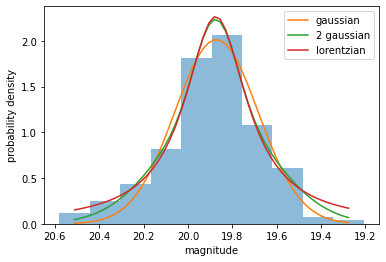

In [27]:
functions.fit_mag(806203100057047)